In [42]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import torchvision
import gzip
import cv2
import matplotlib.pyplot as plt
from dataset import DealDataset
from config import CFG

trainDataset = DealDataset('dataset/MNIST/raw', "train-images-idx3-ubyte.gz",
                           "train-labels-idx1-ubyte.gz", transform=transforms.ToTensor())
testDataset = DealDataset('dataset/MNIST/raw', "t10k-images-idx3-ubyte.gz",
                          "t10k-labels-idx1-ubyte.gz", transform=transforms.ToTensor())

# 训练数据和测试数据的装载


NameError: name 'gzip' is not defined

In [26]:
train_loader = torch.utils.data.DataLoader(
    dataset=trainDataset,
    batch_size=CFG.batch,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=testDataset,
    batch_size=CFG.batch,
    shuffle=False,
)

In [27]:
class MLP(torch.nn.Module):
    def __init__(self,linear:list):
        super().__init__()
        self.linears = torch.nn.ModuleList([torch.nn.Linear(linear[i],linear[i+1]) for i in range(len(linear)-1)])
        self.activation = torch.nn.ReLU()
        print(len(self.linears))
    def forward(self,x):
        for i,net in enumerate(self.linears):
            x = net(x)
            if i != len(self.linears)-1:
                x = self.activation(x)
        return x


4
tensor([[ 0.2106, -0.0132,  0.0346,  ...,  0.0341, -0.0940, -0.0768],
        [ 0.2343, -0.0062,  0.0337,  ...,  0.0511, -0.0672, -0.0791],
        [ 0.2233,  0.0006,  0.0383,  ...,  0.0475, -0.0796, -0.0791],
        ...,
        [ 0.2255, -0.0070,  0.0302,  ...,  0.0423, -0.0624, -0.0944],
        [ 0.2138, -0.0064,  0.0337,  ...,  0.0442, -0.0782, -0.0755],
        [ 0.2016,  0.0023,  0.0304,  ...,  0.0287, -0.0975, -0.0558]],
       grad_fn=<AddmmBackward0>)
tensor([6, 6, 2, 4, 1, 2, 1, 3, 9, 8, 7, 2, 1, 5, 0, 3, 4, 5, 2, 5, 2, 6, 7, 4,
        2, 1, 1, 7, 7, 2, 1, 7, 6, 7, 3, 2, 8, 6, 0, 5, 1, 2, 1, 6, 9, 6, 2, 1,
        6, 6, 4, 1, 7, 0, 6, 0, 4, 2, 0, 5, 9, 3, 7, 7, 2, 1, 8, 9, 6, 5, 9, 2,
        5, 7, 3, 8, 0, 1, 6, 2, 3, 9, 5, 0, 4, 6, 3, 3, 6, 5, 0, 9, 7, 0, 8, 2,
        7, 8, 1, 0, 6, 7, 9, 4, 0, 1, 8, 9, 4, 5, 0, 5, 3, 8, 6, 5, 6, 0, 2, 7,
        4, 9, 7, 0, 8, 0, 4, 4])


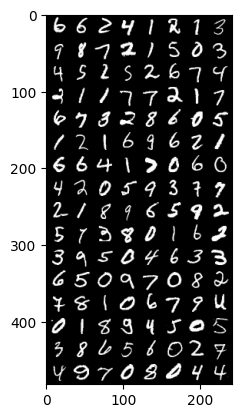

In [33]:
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1, 2, 0)



a = MLP(CFG.linear)


loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(a.parameters(), lr=1e-3, momentum=0.9)




print(a(images.view(-1,28*28)))
# std = [0.5, 0.5, 0.5]
# mean = [0.5, 0.5, 0.5]
# img = img * std + mean
print(labels)
plt.imshow(img)
plt.show()

In [34]:
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
device = "cuda" if torch.cuda.is_available() else "cpu"
def train(dataloader, model, loss_fn, optimizer):

    # Total size of dataset for reference
    size = 0

    # places your model into training mode
    model.train()

    # loss batch
    batch_loss = {}
    batch_accuracy = {}

    correct = 0
    _correct = 0



    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):

        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)

        # Compute prediction error / loss
        # 1. Compute y_pred
        # 2. Compute loss between y and y_pred using selectd loss function

        y_pred = model(X.view(-1,28*28))
        loss = loss_fn(y_pred, y)

        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)

        correct += _correct

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size

        size += _batch_size

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    correct/=size
    print(f"Train Accuracy: {(100*correct):>0.1f}%")

    return batch_loss , batch_accuracy

In [35]:
def validation(dataloader, model, loss_fn):

    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)

    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0

    _correct = 0
    _batch_size = 0

    batch_loss = {}
    batch_accuracy = {}

    with torch.no_grad():

        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X.view(-1,28*28))

            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)

            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct

            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size




    ## Calculating loss based on loss function defined
    test_loss /= num_batches

    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size

    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return batch_loss , batch_accuracy

In [36]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = train(train_loader, a, loss_fn, optimizer)
    _valid_batch_loss , _valid_batch_accuracy = validation(test_loader, a, loss_fn)
    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))
    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))
print("Done!")

Epoch 1
-------------------------------
loss: 2.320017  [    0]
loss: 2.297603  [12800]
loss: 2.294014  [25600]
loss: 2.296030  [38400]
loss: 2.285979  [51200]
Train Accuracy: 10.4%
Valid Error: 
 Accuracy: 18.7%, Avg loss: 2.277821 

Epoch 2
-------------------------------
loss: 2.277070  [    0]
loss: 2.271199  [12800]
loss: 2.237012  [25600]
loss: 2.227271  [38400]
loss: 2.208243  [51200]
Train Accuracy: 22.8%
Valid Error: 
 Accuracy: 27.4%, Avg loss: 2.160510 

Epoch 3
-------------------------------
loss: 2.175837  [    0]
loss: 2.074042  [12800]
loss: 2.036329  [25600]
loss: 1.878013  [38400]
loss: 1.747424  [51200]
Train Accuracy: 41.6%
Valid Error: 
 Accuracy: 56.0%, Avg loss: 1.568555 

Epoch 4
-------------------------------
loss: 1.555789  [    0]
loss: 1.285792  [12800]
loss: 1.143475  [25600]
loss: 1.096627  [38400]
loss: 0.801111  [51200]
Train Accuracy: 67.7%
Valid Error: 
 Accuracy: 76.7%, Avg loss: 0.792181 

Epoch 5
-------------------------------
loss: 0.664271  [   